## The Keras functional API

### Setup

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [58]:
tf.keras.backend.clear_session()

### Introduction

In [59]:
inputs = keras.Input(shape=(784, ))
img_inputs = keras.Input(shape=(32, 32, 3))
print(inputs.shape)
print(img_inputs.shape)

(None, 784)
(None, 32, 32, 3)


In [60]:
img_inputs

<tf.Tensor 'input_2:0' shape=(None, 32, 32, 3) dtype=float32>

In [61]:
inputs

<tf.Tensor 'input_1:0' shape=(None, 784) dtype=float32>

In [62]:
inputs.dtype

tf.float32

In [63]:
dense = layers.Dense(64, activation=tf.nn.relu)

In [64]:
x = dense(inputs)

In [65]:
x.shape

TensorShape([None, 64])

In [66]:
outputs = layers.Dense(10)(x)

In [67]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

In [68]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


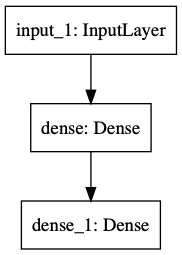

In [71]:
keras.utils.plot_model(model, 'my_first_model.png')

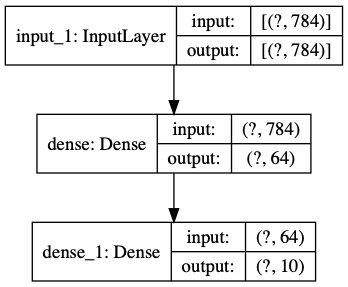

In [72]:
keras.utils.plot_model(model, 'my_first_model_with_info.png', show_shapes=True)

### Training, evaluation, and inference

In [95]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [96]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 1s 18us/sample - loss: 0.3701 - acc: 0.8978 - val_loss: 0.2274 - val_acc: 0.9360
Epoch 2/5
48000/48000 [==============================] - 1s 16us/sample - loss: 0.1952 - acc: 0.9440 - val_loss: 0.1678 - val_acc: 0.9523
Epoch 3/5
48000/48000 [==============================] - 1s 17us/sample - loss: 0.1467 - acc: 0.9565 - val_loss: 0.1381 - val_acc: 0.9598
Epoch 4/5
48000/48000 [==============================] - 1s 16us/sample - loss: 0.1168 - acc: 0.9656 - val_loss: 0.1295 - val_acc: 0.9628
Epoch 5/5
48000/48000 [==============================] - 1s 16us/sample - loss: 0.0982 - acc: 0.9709 - val_loss: 0.1220 - val_acc: 0.9653
10000/10000 - 0s - loss: 0.1194 - acc: 0.9659


In [97]:
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Test loss: 0.11935262060724199
Test accuracy: 0.9659


### Save and serialize

In [98]:
model.save('my_model_mnist')
del model
model = keras.models.load_model('my_model_mnist')

ValueError: Unknown entries in loss dictionary: ['config', 'class_name']. Only expected following keys: ['dense_1']

### Use the same graph of layers to define multiple models

In [101]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation=tf.nn.relu)(encoder_input)
x = layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = layers.Conv2D(16, 3, activation=tf.nn.relu)(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation=tf.nn.relu)(x)
x = layers.Conv2DTranspose(32, 3, activation=tf.nn.relu)(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation=tf.nn.relu)(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation=tf.nn.relu)(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   

### All models are callable, just like layers

In [7]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation=tf.nn.relu)(encoder_input)
x = layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = layers.Conv2D(16, 3, activation=tf.nn.relu)(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16, ), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation=tf.nn.relu)(x)
x = layers.Conv2DTranspose(32, 3, activation=tf.nn.relu)(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(32, 3, activation=tf.nn.relu)(x)
decoder_output = layers.Conv2DTranspose(16, 3, activation=tf.nn.relu)(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 16)                0   

In [25]:
def get_model():
    inputs = keras.Input(shape=(128, ))
    x = layers.Dense(256, activation=tf.nn.relu)(inputs)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [26]:
inputs = keras.Input(shape=(128, ))
model_1 = get_model()(inputs)
model_2 = get_model()(inputs)
model_3 = get_model()(inputs)

outputs = layers.average([model_1, model_2, model_3])
ensemble_model = keras.Model(inputs, outputs)
ensemble_model.summary()

X = np.random.random((1000, 128))
y = np.random.randint(0, 2, size=(1000, 1))

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
model_20 (Model)                (None, 1)            33281       input_23[0][0]                   
__________________________________________________________________________________________________
model_21 (Model)                (None, 1)            33281       input_23[0][0]                   
__________________________________________________________________________________________________
model_22 (Model)                (None, 1)            33281       input_23[0][0]                   
___________________________________________________________________________________________

In [27]:
ensemble_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
ensemble_model.fit(X, y, epochs=20, batch_size=32)

Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 797us/sample - loss: 1.3402 - accuracy: 0.4610
Epoch 2/20
1000/1000 [==============================] - 0s 92us/sample - loss: 0.7140 - accuracy: 0.5280
Epoch 3/20
1000/1000 [==============================] - 0s 106us/sample - loss: 0.6594 - accuracy: 0.6010
Epoch 4/20
1000/1000 [==============================] - 0s 101us/sample - loss: 0.6440 - accuracy: 0.6310
Epoch 5/20
1000/1000 [==============================] - 0s 94us/sample - loss: 0.6329 - accuracy: 0.6470
Epoch 6/20
1000/1000 [==============================] - 0s 92us/sample - loss: 0.6476 - accuracy: 0.6220
Epoch 7/20
1000/1000 [==============================] - 0s 90us/sample - loss: 0.7021 - accuracy: 0.5850
Epoch 8/20
1000/1000 [==============================] - 0s 90us/sample - loss: 0.6729 - accuracy: 0.6020
Epoch 9/20
1000/1000 [==============================] - 0s 96us/sample - loss: 0.5928 - accuracy: 0.6970
Epoch 10/20
1000/1000 [=======

In [49]:
inputs_1 = keras.Input(shape=(128, ))
inputs_2 = keras.Input(shape=(128, ))
inputs_3 = keras.Input(shape=(128, ))

model_1 = get_model()(inputs_1)
model_2 = get_model()(inputs_2)
model_3 = get_model()(inputs_3)

outputs = layers.average([model_1, model_2, model_3])
ensemble_model = keras.Model([inputs_1, inputs_2, inputs_3], outputs)
ensemble_model.summary()

X_1 = np.random.random((1000, 128))
X_2 = np.random.random((1000, 128))**2
X_3 = np.random.random((1000, 128)) + 10
y = np.random.randint(0, 2, size=(1000, 1))

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
model_39 (Model)                (None, 1)            33281       input_43[0][0]                   
___________________________________________________________________________________________

In [50]:
ensemble_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
ensemble_model.fit([X_1, X_2, X_3], y, epochs=20, batch_size=32)

Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 809us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 2/20
1000/1000 [==============================] - 0s 101us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 3/20
1000/1000 [==============================] - 0s 130us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 4/20
1000/1000 [==============================] - 0s 106us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 5/20
1000/1000 [==============================] - 0s 96us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 6/20
1000/1000 [==============================] - 0s 91us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 7/20
1000/1000 [==============================] - 0s 100us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 8/20
1000/1000 [==============================] - 0s 117us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 9/20
1000/1000 [==============================] - 0s 116us/sample - loss: 7.7279 - accuracy: 0.4990
Epoch 10/20
1000/1000 [===

### Manipulate complex graph topologies

In [73]:
num_tags = 12
num_words = 10000
num_departments = 4

title_input = keras.Input(shape=(None, ), name='title')
body_input = keras.Input(shape=(None, ), name='body')
tags_input = keras.Input(shape=(num_tags, ), name='tags')

title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)

title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(128)(body_features)

x = layers.concatenate([title_features, body_features, tags_input])
priority_pred = layers.Dense(1, name='priority')(x)
department_pred = layers.Dense(num_departments, name='departments')(x)

model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      body[0][0]                       
______________________________________________________________________________________________

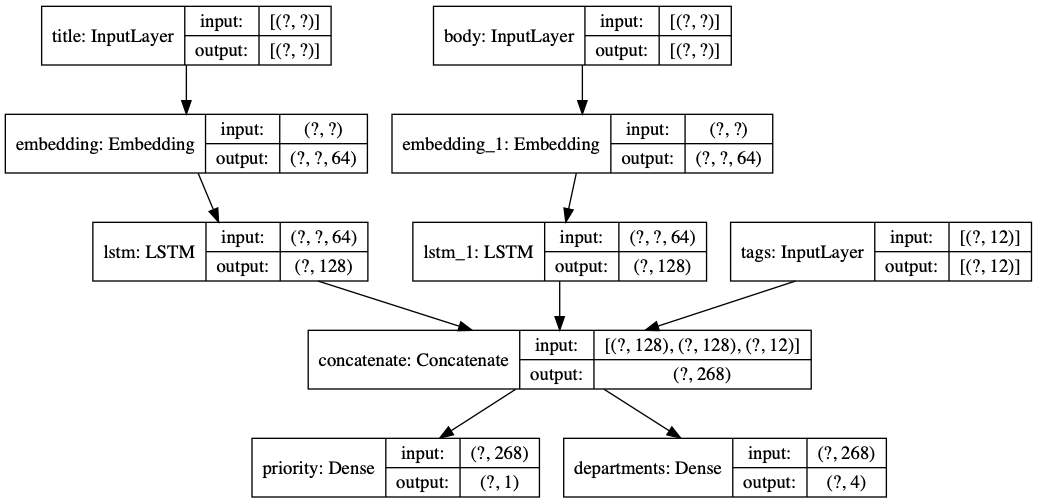

In [74]:
keras.utils.plot_model(model, 'model_with_multiple.png', show_shapes=True)

In [79]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss={
                  'priority':
                  tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  'departments':
                  tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              },
              loss_weights=[1, 0.2],
              metrics=['accuracy'])

In [80]:
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit({
    'title': title_data,
    'body': body_data,
    'tags': tags_data
}, {
    'priority': priority_targets,
    'departments': dept_targets
},
          epochs=10,
          batch_size=32)

Train on 1280 samples
Epoch 1/10
1280/1280 [==============================] - 4s 3ms/sample - loss: 1.2454 - priority_loss: 0.6998 - departments_loss: 2.7279 - priority_accuracy: 0.0000e+00 - departments_accuracy: 0.2516
Epoch 2/10
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.2399 - priority_loss: 0.6972 - departments_loss: 2.7135 - priority_accuracy: 0.0000e+00 - departments_accuracy: 0.2625
Epoch 3/10
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.2414 - priority_loss: 0.6999 - departments_loss: 2.7076 - priority_accuracy: 0.0000e+00 - departments_accuracy: 0.2914
Epoch 4/10
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.2390 - priority_loss: 0.6974 - departments_loss: 2.7079 - priority_accuracy: 0.0000e+00 - departments_accuracy: 0.3258
Epoch 5/10
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.2381 - priority_loss: 0.6964 - departments_loss: 2.7081 - priority_accuracy: 0.0000e+00 - departments_

In [83]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation=tf.nn.relu)(inputs)
x = layers.Conv2D(64, 3, activation=tf.nn.relu)(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same')(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation=tf.nn.relu)(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation=tf.nn.relu)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name='toy_resnet')
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_10[0][0]                  
_________________________________________________________________________________________

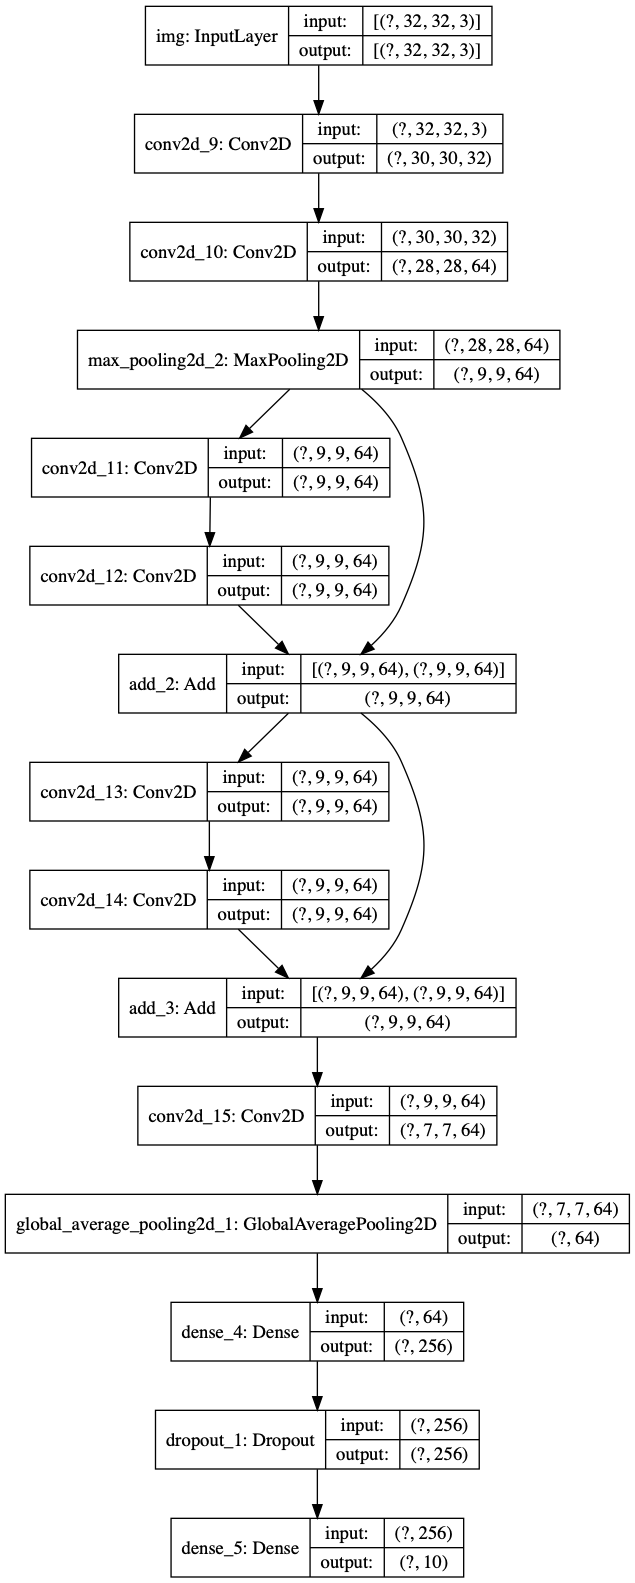

In [84]:
keras.utils.plot_model(model, 'mini_resnet.png', show_shapes=True)

In [85]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 38s 0us/step


In [86]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

In [87]:
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 61s 2ms/sample - loss: 1.9090 - acc: 0.2744 - val_loss: 1.5111 - val_acc: 0.4263
Epoch 2/5
40000/40000 [==============================] - 64s 2ms/sample - loss: 1.4782 - acc: 0.4536 - val_loss: 1.4695 - val_acc: 0.4560
Epoch 3/5
40000/40000 [==============================] - 73s 2ms/sample - loss: 1.2634 - acc: 0.5443 - val_loss: 1.2107 - val_acc: 0.5537
Epoch 4/5
40000/40000 [==============================] - 69s 2ms/sample - loss: 1.1021 - acc: 0.6091 - val_loss: 1.1889 - val_acc: 0.5933
Epoch 5/5
40000/40000 [==============================] - 66s 2ms/sample - loss: 0.9787 - acc: 0.6573 - val_loss: 1.0076 - val_acc: 0.6400


### Shared layers

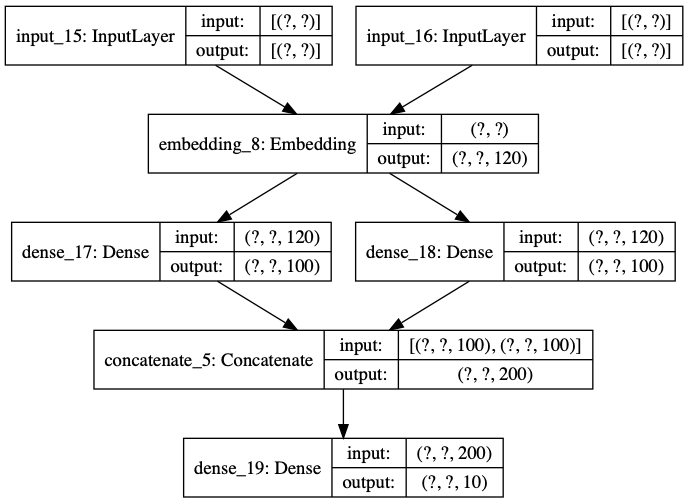

In [94]:
shared_embedding = layers.Embedding(1000, 120)
text_input_a = keras.Input(shape=(None, ), dtype='int32')
text_input_b = keras.Input(shape=(None, ), dtype='int32')

encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

x_1 = layers.Dense(100)(encoded_input_a)
x_2 = layers.Dense(100)(encoded_input_b)

x = layers.concatenate([x_1, x_2])
outputs = layers.Dense(10)(x)
model = keras.Model([text_input_a, text_input_b], outputs)
keras.utils.plot_model(model, 'layer_shared.png', show_shapes=True)

### Extract and reuse nodes in the graph of layers

In [95]:
vgg19 = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 106s 0us/step


In [96]:
features_list = [layer.output for layer in vgg19.layers]

In [101]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

In [102]:
img = np.random.random((1, 224, 224, 3)).astype('float32')

In [107]:
feat_extraction_model(img)
feat_extraction_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

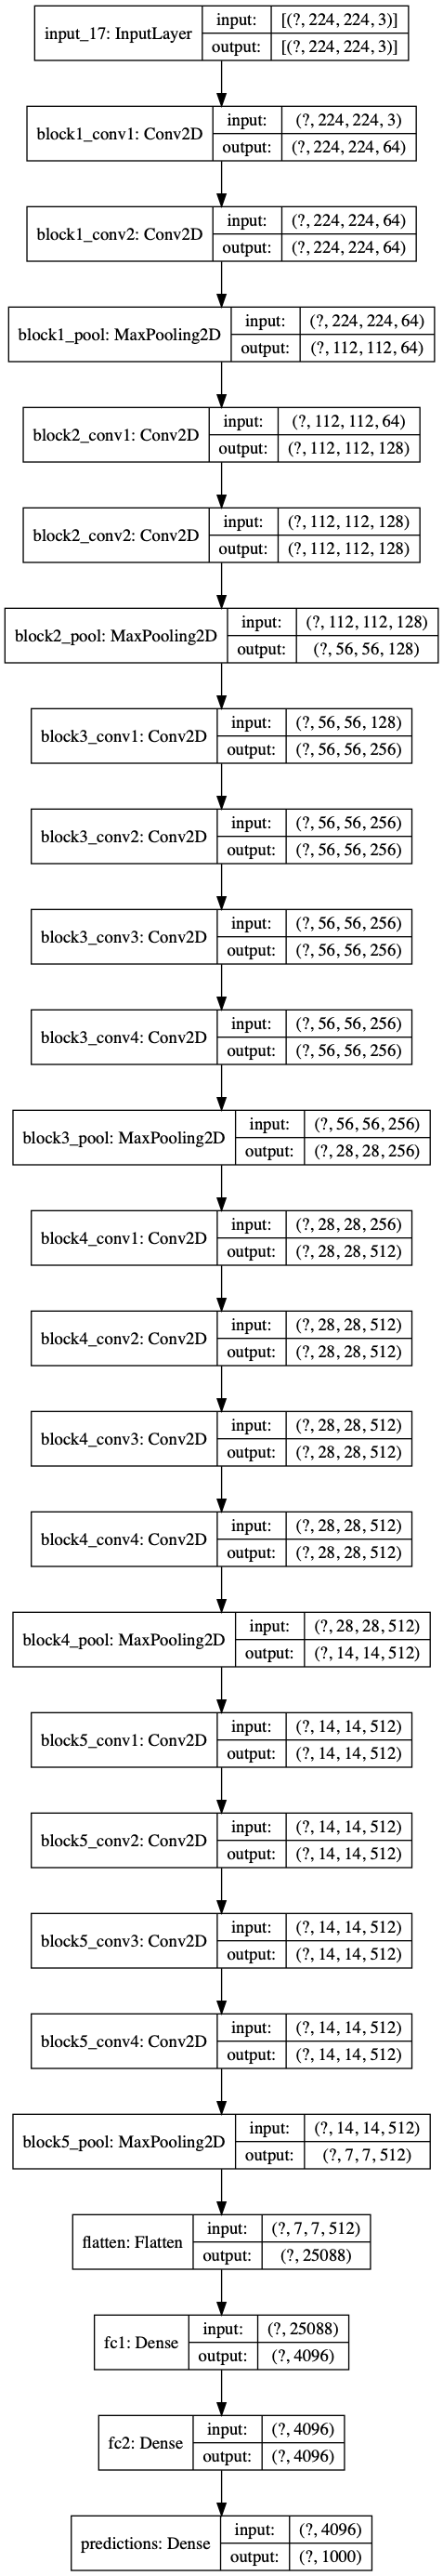

In [108]:
keras.utils.plot_model(feat_extraction_model,
                       'many_output.png',
                       show_shapes=True)

### Extend the API using custom layers

In [123]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)

        self.b = self.add_weight(shape=(self.units, ),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {'units': self.units}

    def from_config(cls, config):
        return cls(**config)


inputs = keras.Input((4, ))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
model.summary()
config = model.get_config()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
custom_dense_5 (CustomDense) (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [124]:
config

{'name': 'model_9',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_23'},
   'name': 'input_23',
   'inbound_nodes': []},
  {'class_name': 'CustomDense',
   'config': {'units': 10},
   'name': 'custom_dense_5',
   'inbound_nodes': [[['input_23', 0, 0, {}]]]}],
 'input_layers': [['input_23', 0, 0]],
 'output_layers': [['custom_dense_5', 0, 0]]}

### Mix-and-match API styles

In [183]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16

inputs = keras.Input((None, units))
x = layers.Dense(64)(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [184]:
class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation='tanh')
        self.projection_2 = layers.Dense(units=units, activation='tanh')
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


In [185]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, None, 32)]        0         
_________________________________________________________________
dense_59 (Dense)             (None, None, 64)          2112      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 65        
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


In [193]:
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3, padding='same')(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

(16, 10, 32)


In [194]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(16, 10, 5)]             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (16, 10, 32)              512       
_________________________________________________________________
custom_rnn_18 (CustomRNN)    (16, 10, 1)               2145      
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [195]:
rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))

(1, 10, 32)


In [197]:
type(_)

tensorflow.python.framework.ops.EagerTensor